In [362]:
import pandas as np
import numpy as np
# import tensorflow as tf
# import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from datetime import timedelta
import pandas as pd
import talib
import warnings
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

[*********************100%***********************]  2 of 2 completed


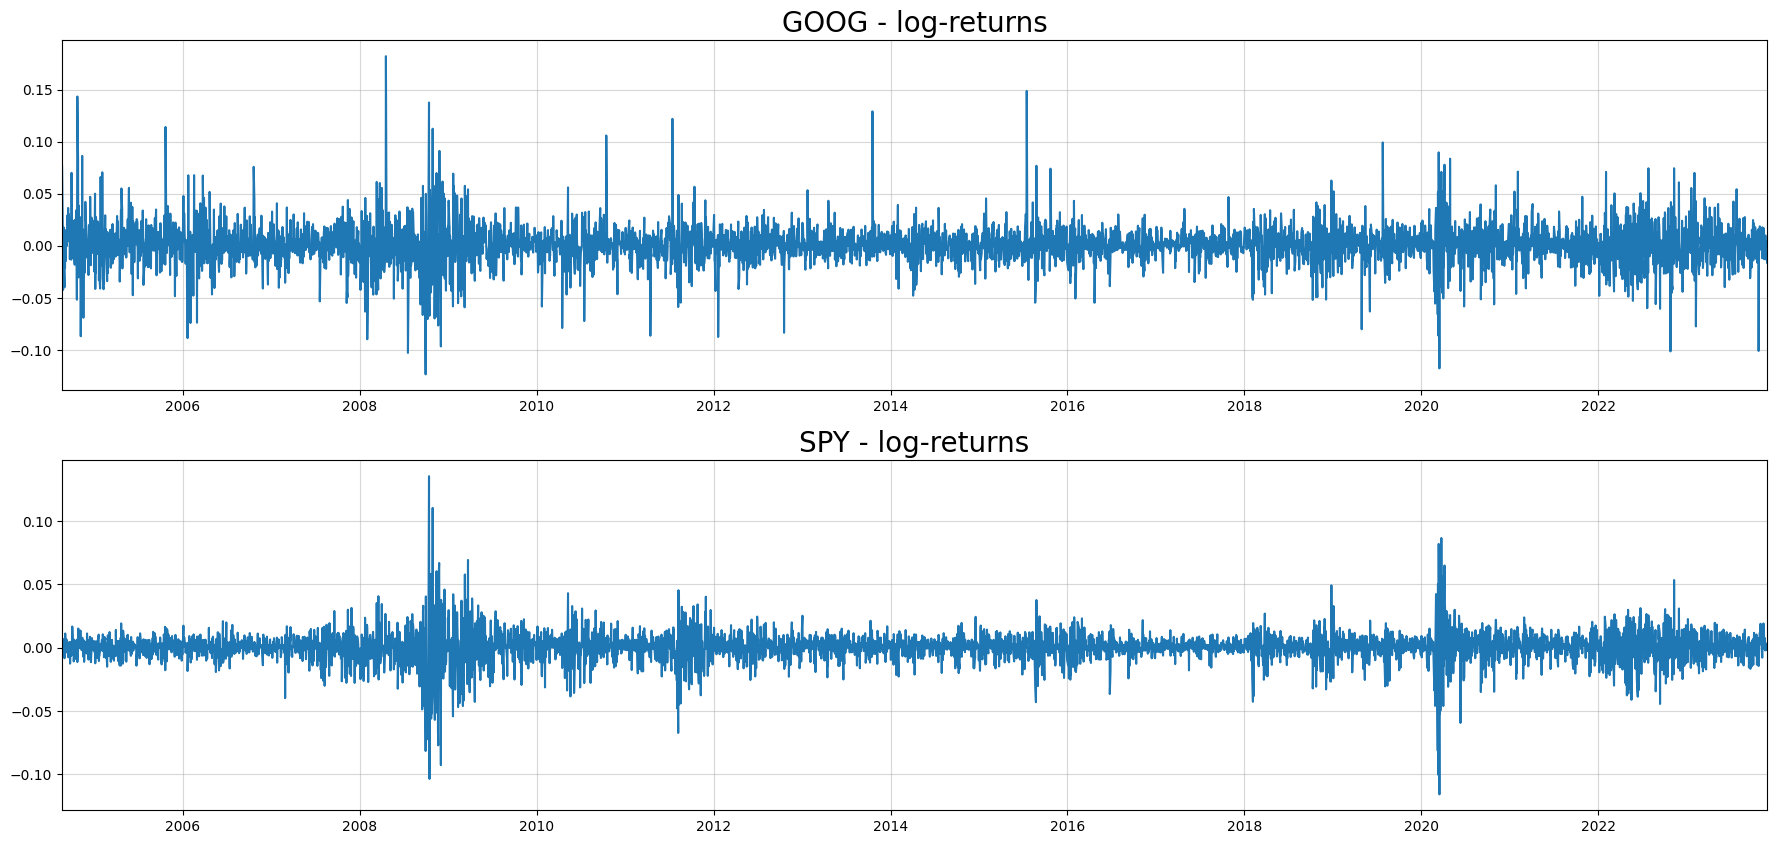

In [363]:
import yfinance as yf
data = yf.download("GOOG SPY", start="2000-01-01", end="2023-11-30", interval="1d")

close = data["Close"]
returns = np.log(close).diff().dropna()


fig, axs = plt.subplots(2,1, figsize = (22,5*2))

for i in range(2):
    axs[i].plot(returns.iloc[:,i])
    axs[i].grid(alpha=0.5)
    axs[i].margins(x=0)
    axs[i].set_title("{} - log-returns".format(returns.columns[i]),size=20)

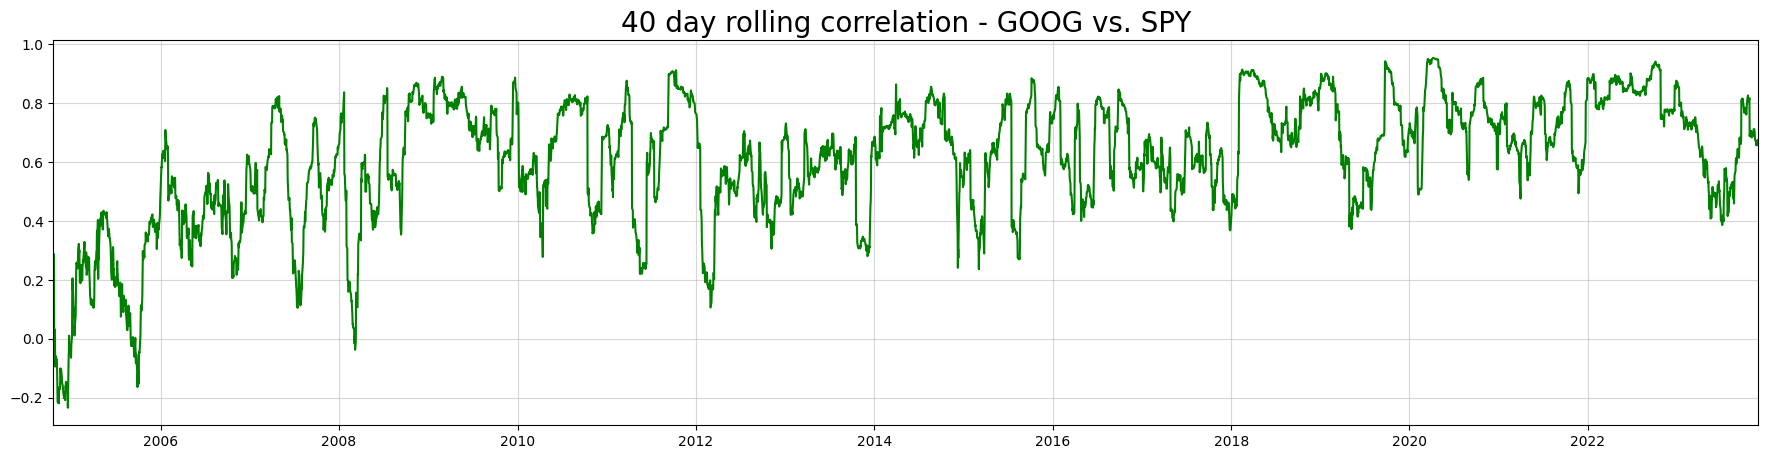

In [364]:
rolling_corrs = returns.rolling(40,min_periods=0).corr()
goog_spy_rollcorr = rolling_corrs["GOOG"][rolling_corrs.index.get_level_values(1)=="SPY"]
plt.figure(figsize = (22,5))

plt.title("40 day rolling correlation - GOOG vs. SPY",size=20)
plt.plot(returns.index[40:],goog_spy_rollcorr.values[40:],c="green", label="40 day rolling correlation")
plt.grid(alpha=0.5)
plt.margins(x=0)

In [365]:
label = returns.rolling(40).corr()["GOOG"][rolling_corrs.index.get_level_values(1)=="SPY"].droplevel(1).shift(-40).dropna()

In [366]:
def compute_factors(data):
    df = data

    # Create an empty DataFrame to hold signals
    signals = pd.DataFrame(index=df.index)

    # 1. Moving Average
    for i in range(6,51,4):
        signals[f'SMA_{i}'] = talib.SMA(df['Adj Close'], timeperiod=i)

    # 2. EMA - Exponential Moving Average
    for i in range(6,51,4):
        signals[f'EMA_{i}'] = talib.EMA(df['Adj Close'], timeperiod=i)

    # 3. VWMA - Volume Weighted Moving Average
    vol_price = df['Volume'] * df['Adj Close']
    for i in range(6,51,4):
        signals[f'VSMA_{i}'] = talib.SMA(vol_price, timeperiod=i)

    # 4. BBANDS - Bollinger Bands with different timeperiod
    for i in range(14,61,6):
        upper, middle, lower = talib.BBANDS(df['Adj Close'], timeperiod=i)
        signals[f'BBANDS_upper_{i}'] = upper
        signals[f'BBANDS_middle_{i}'] = middle
        signals[f'BBANDS_lower_{i}'] = lower

    # 5. MOM - Momentum
    for i in range(14,61,6):
        signals[f'MOM_{i}'] = talib.MOM(df['Adj Close'], timeperiod=i)


    # 6. Acceleration - Difference in the change of momentum

    for i in range(14,61,6):
        signals[f'ACCEL_{i}'] = signals[f'MOM_{i}'].diff()


    # 7. Rate of Change - Rate change of Price

    for i in range(14,61,6):
        signals[f'ROCR_{i}'] = df['Adj Close'].pct_change(i)

    # 6. Moving Average Convergence Divergence
    for i in [18,24,30]:
        macd, macdsignal, macdhist = talib.MACD(df['Adj Close'], fastperiod=12, slowperiod=i)
        signals[f'MACD_12_{i}'] = macd

    # 7. RSI
    for i in [8,14,20]:
        signals[f'RSI_{i}'] = talib.RSI(df['Adj Close'], timeperiod=i)

    # 8. Stochastic Oscillator
    for i in range(10,23,4):
        slowk, slowd = talib.STOCH(df['High'], df['Low'], df['Adj Close'], fastk_period=i)
        signals[f'STOCH_{i}'] = slowk

    # 9. Williams' %R
    signals['WILLR_14'] = talib.WILLR(df['High'], df['Low'], df['Adj Close'], timeperiod=14)

    # 10. MFI - Money Flow Index
    signals['MFI_14'] = talib.MFI(df['High'], df['Low'], df['Adj Close'], df['Volume'], timeperiod=14)

    #11. Chaikin's Volatility
    signals['CHV_10'] = talib.ADOSC(df['High'], df['Low'], df['Adj Close'], df['Volume'], fastperiod=3, slowperiod=10)


    # 12. AD - Chaikin A/D Line
    signals['AD'] = talib.AD(df['High'], df['Low'], df['Adj Close'], df['Volume']).diff()

    # 13.Psychological Line Indicator
    signals['PSY'] =(df['Adj Close'] > df['Adj Close'].shift(1)).rolling(window=14).sum() / 14 * 100

    # 14.Commodity Channel Index
    signals['CCI_5'] = talib.CCI(df['High'], df['Low'], df['Adj Close'], timeperiod=5)

    # 15. Average Directional Movement Index
    for i in range(14,61,6):
        signals[f'ADX_{i}'] = talib.ADX(df['High'], df['Low'], df['Adj Close'], timeperiod=i)

    # 16.ATR - Average True Range
    for i in range(14,61,6):
        signals[f'ATR_{i}'] = talib.ATR(df['High'], df['Low'], df['Adj Close'], timeperiod=i)

    # 17. HT_TRENDLINE - Hilbert Transform - Instantaneous Trendline
    signals['HT_TRENDLINE'] = talib.HT_TRENDLINE(df['Adj Close'])

    # 18. CMO - Chande Momentum Oscillator
    for i in range(14,61,6):
        signals[f'CMO_{i}'] = talib.CMO(df['Adj Close'], timeperiod=i)

    # 19 PPO - Percentage Price Oscillator
    signals['PPO'] = talib.PPO(df['Adj Close'], fastperiod=12, slowperiod=26, matype=0)


    # 20. TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
    for i in range(14,61,6):
        signals[f'TRIX_{i}'] = talib.TRIX(df['Adj Close'], timeperiod=i)

    # 21. WCLPRICE - Weighted Close Price
    signals['WCLPRICE'] = talib.WCLPRICE(df['High'], df['Low'], df['Adj Close'])

    # 22. HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period
    signals['HT_DCPERIOD'] = talib.HT_DCPERIOD(df['Adj Close'])

    # 23. HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase
    signals['HT_DCPHASE'] = talib.HT_DCPHASE(df['Adj Close'])
    
    signals.index = df.index

    return signals

In [367]:
def compute_correlation_factors(data,stock_name):
    
    signals = pd.DataFrame(index=data.index)
    
    for i in range(5,60,5):
        rolling_corrs = data.rolling(i).corr()

        signals[f'corr_{i}'] = rolling_corrs[stock_name][rolling_corrs.index.get_level_values(1)=="SPY"].droplevel(1)
    
    for i in range(14,40,6):
        signals[f'corr_MOM_{i}'] = talib.MOM(signals['corr_40'], timeperiod=i)

    for i in range(6,40,4):
        signals[f'corr_EMA_{i}'] = talib.EMA(signals['corr_40'], timeperiod=i)
        
        
    for i in range(14,40,6):
        signals[f'corr_ROCR_{i}'] = signals['corr_40'].pct_change(i)
        
    for i in range(6,40,4):
        signals[f'corr_volatility_{i}'] = signals['corr_40'].rolling(i).std()
        
    return signals
        
        

In [368]:
stock_df = yf.download("GOOG", start="2000-01-01", end="2023-11-30", interval="1d")
index_df = yf.download("SPY", start="2000-01-01", end="2023-11-30", interval="1d")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [421]:
stock_name = "GOOG"
stock_signals = compute_factors(stock_df).dropna()
stock_signals.columns = [stock_name+"_"+i for i in stock_signals.columns]

index_signals = compute_factors(index_df).dropna()
index_signals.columns = ["SPY_"+i for i in index_signals.columns]

corr_signals = compute_correlation_factors(returns,stock_name)

merged_df = pd.concat([stock_signals,index_signals,corr_signals,label],axis=1).dropna()

label.name = 'label'
merged_df = pd.concat([stock_signals,index_signals,corr_signals,label],axis=1).dropna()

for stock_name in ["AMZN", "JPM", "GME","XOM"]:
    stock_df = yf.download(stock_name, start="2000-01-01", end="2023-11-30", interval="1d")
    stock_signals = compute_factors(stock_df).dropna()
    stock_signals.columns = [stock_name+"_"+i for i in stock_signals.columns]
    merged_df = pd.concat([merged_df,stock_signals],axis=1).dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [429]:
merged_df = merged_df[list(merged_df.columns.difference(['label']).values) + ['label']]

In [431]:

scaler = MinMaxScaler()

X_train = merged_df.loc[:'2023-01-01'].iloc[:,:-1]
X_test = merged_df.loc['2023-01-01':].iloc[:,:-1]
Y_train = merged_df.loc[:'2023-01-01'].iloc[:,-1].values
Y_test = merged_df.loc['2023-01-01':].iloc[:,-1].values


X_train =  scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

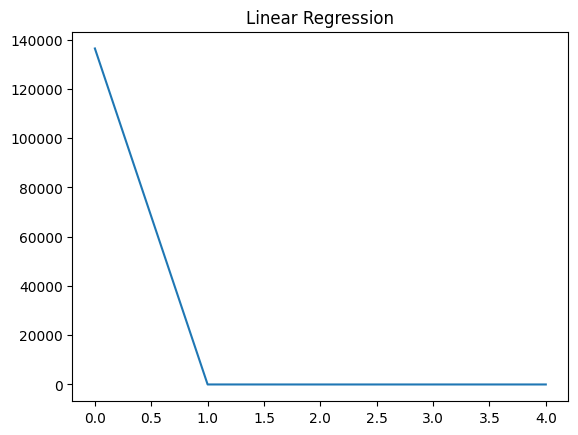

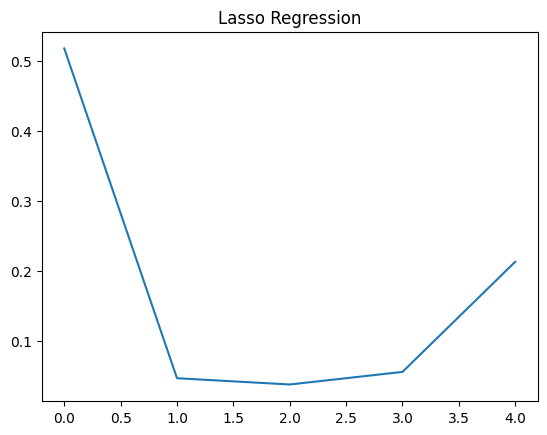

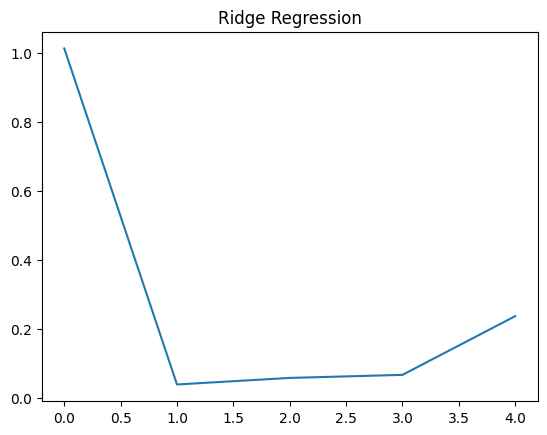

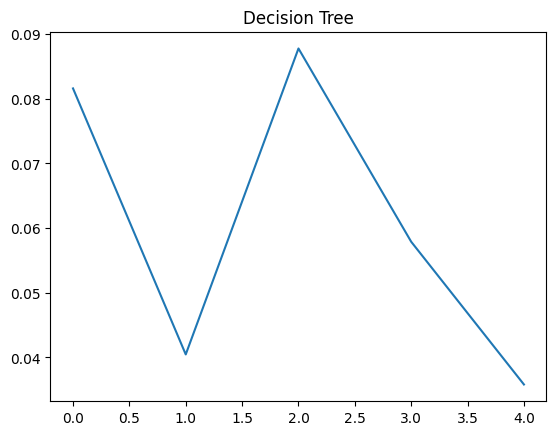

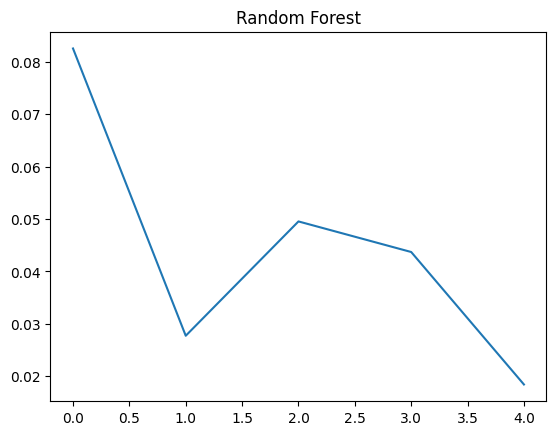

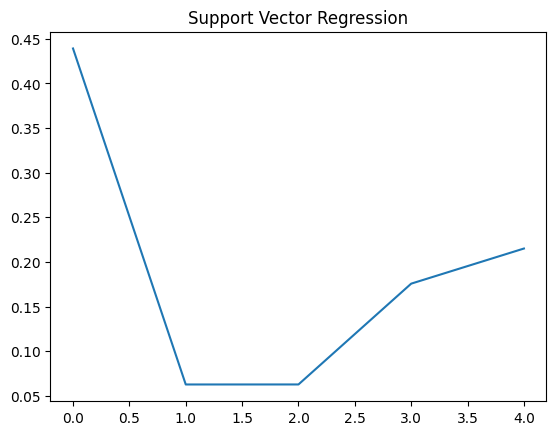

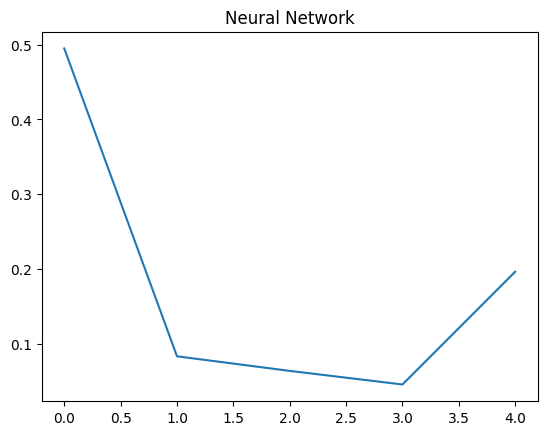

Model Selection Results:
Linear Regression: MSE=4.499312380527869
Lasso Regression: MSE=0.08793510105591532
Ridge Regression: MSE=0.10000544034187214
Decision Tree: MSE=0.05549135505996431
Random Forest: MSE=0.034861133182055186
Support Vector Regression: MSE=0.12899705206529824
Neural Network: MSE=0.09715689850133948

Best Model: Random Forest
Best Model MSE on Testing Set: 0.0023229037398141026


In [175]:
# 定义模型
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression':Lasso(alpha = 1e-4),
    'Ridge Regression':Ridge(alpha = 1),
    'Decision Tree': DecisionTreeRegressor(max_depth=15),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=5),
    'Support Vector Regression': SVR(kernel='rbf', C=10, epsilon=0.1),
    'Neural Network': MLPRegressor(max_iter=500)
}

# 设置时间序列交叉验证
tscv = TimeSeriesSplit(n_splits=5)

results = {}

for model_name, model in models.items():
    temp_scores = []
    for train_index, val_index in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = Y_train[train_index], Y_train[val_index]
        
        model.fit(X_train_fold, y_train_fold)
        predictions = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, predictions)
        temp_scores.append(mse)
    plt.plot(temp_scores)
    plt.title(model_name)
    plt.show()
    avg_mse = sum(temp_scores[1:]) / (len(temp_scores)-1)
    results[model_name] = avg_mse

# 挑选最佳模型
best_model = min(results, key=results.get)
best_model_instance = models[best_model]

# 训练最佳模型
best_model_instance.fit(X_train, Y_train)

# 在测试集上进行预测
predictions = best_model_instance.predict(X_test)
mse = mean_squared_error(Y_test, predictions)

# 打印结果
print("Model Selection Results:")
for model, mse_score in results.items():
    print(f"{model}: MSE={mse_score}")

print(f"\nBest Model: {best_model}")
print(f"Best Model MSE on Testing Set: {mse}")


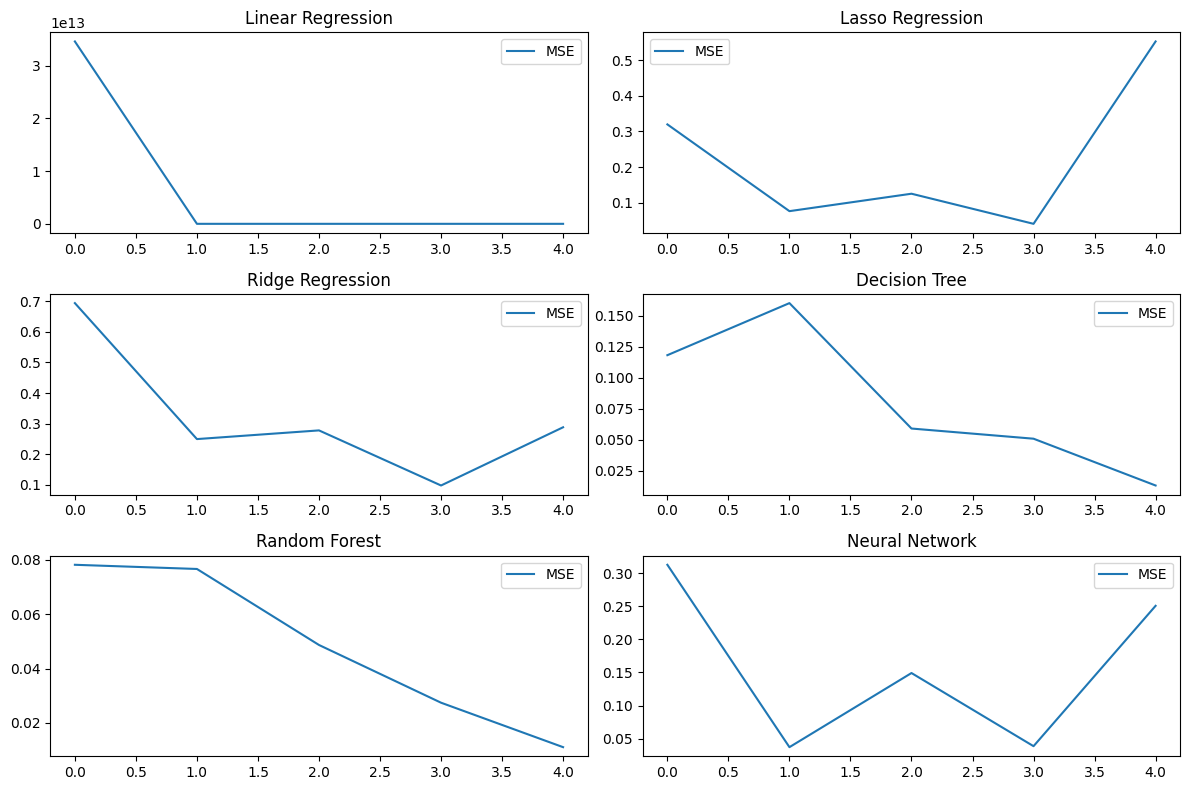

               Model           MSE        R2
0  Linear Regression  6.913354e+12  0.987073
1   Lasso Regression  2.227368e-01  0.802774
2   Ridge Regression  3.214913e-01  0.841367
3      Decision Tree  8.020139e-02  0.999432
4      Random Forest  4.839600e-02  0.883529
5     Neural Network  1.576725e-01  0.800066


In [432]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression':Lasso(alpha = 1e-4),
    'Ridge Regression':Ridge(alpha = 1),
    'Decision Tree': DecisionTreeRegressor(max_depth=15),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=5),
    'Neural Network': MLPRegressor(max_iter=500)
}


# Assuming X_train, Y_train, X_test, Y_test are defined
# Assuming models is defined and contains all models

# Setting up time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize a DataFrame to store results
results_df = []

# Subplot setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
axes_flat = axes.flatten()


for idx, (model_name, model) in enumerate(models.items()):
    temp_scores = []
    temp_r2_scores = []

    for train_index, val_index in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = Y_train[train_index], Y_train[val_index]

        model.fit(X_train_fold, y_train_fold)
        predictions = model.predict(X_val_fold)
        temp_scores.append(mean_squared_error(y_val_fold, predictions))
        preictions_train = model.predict(X_train_fold)
        temp_r2_scores.append(r2_score(y_train_fold, preictions_train))
        
    ax = axes_flat[idx]

    # Plotting the MSE scores
    ax.plot(temp_scores, label='MSE')
    ax.set_title(model_name)
    ax.legend()

    # Calculating and storing average MSE and R2
    avg_mse = sum(temp_scores) / len(temp_scores)
    avg_r2 = sum(temp_r2_scores) / len(temp_r2_scores)
    results_df.append({'Model': model_name, 'MSE': avg_mse, 'R2': avg_r2})

results_df = pd.DataFrame(results_df)
results_df.columns=['Model', 'MSE', 'R2']
plt.tight_layout()
plt.show()

# Print results table
print(results_df)


In [435]:
# 挑选最佳模型
best_model_instance = RandomForestRegressor(n_estimators=400, max_depth=5)

# 训练最佳模型
best_model_instance.fit(X_train, Y_train)

# 在测试集上进行预测
predictions = best_model_instance.predict(X_test)
mse = mean_squared_error(Y_test, predictions)

# 打印结果
print("Model Selection Results:")
for model, mse_score in results.items():
    print(f"{model}: MSE={mse_score}")

print(f"\nBest Model: {best_model}")
print(f"Best Model MSE on Testing Set: {mse}")

Model Selection Results:
Linear Regression: MSE=4.499312380527869
Lasso Regression: MSE=0.08793510105591532
Ridge Regression: MSE=0.10000544034187214
Decision Tree: MSE=0.05549135505996431
Random Forest: MSE=0.034861133182055186
Support Vector Regression: MSE=0.12899705206529824
Neural Network: MSE=0.09715689850133948

Best Model: Random Forest
Best Model MSE on Testing Set: 0.048702234390691414


In [436]:
pd.Series(best_model_instance.feature_importances_,index = merged_df.loc[:'2023-01-01'].iloc[:,:-1].columns).sort_values(ascending = False).iloc[:20]

JPM_VSMA_50             0.079002
JPM_VSMA_30             0.063529
JPM_VSMA_26             0.049388
SPY_ATR_20              0.036120
JPM_VSMA_46             0.029015
AMZN_BBANDS_lower_50    0.025553
GOOG_ADX_56             0.025051
GOOG_ATR_20             0.024831
AMZN_BBANDS_lower_56    0.023116
SPY_ATR_26              0.019334
JPM_BBANDS_lower_32     0.018633
GOOG_BBANDS_upper_44    0.017413
SPY_ATR_14              0.016781
SPY_ATR_50              0.016755
JPM_BBANDS_lower_14     0.012048
SPY_ATR_32              0.011523
GME_ADX_56              0.011355
JPM_VSMA_38             0.010940
XOM_STOCH_18            0.010839
SPY_ATR_38              0.010748
dtype: float64

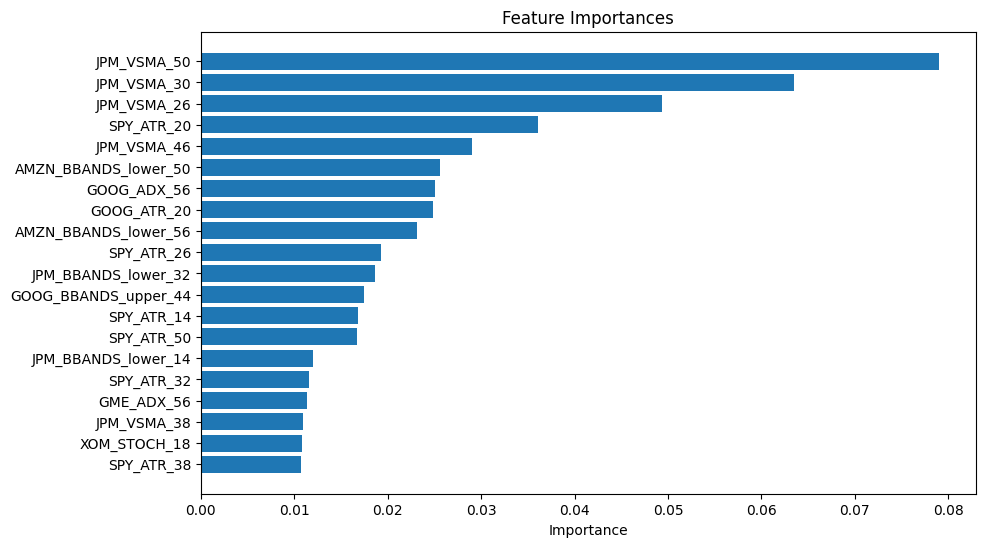

In [437]:
import matplotlib.pyplot as plt

# Extracting and sorting data for plotting
values = pd.Series(best_model_instance.feature_importances_,index = merged_df.loc[:'2023-01-01'].iloc[:,:-1].columns).sort_values(ascending = False).iloc[:20].values
labels = pd.Series(best_model_instance.feature_importances_,index = merged_df.loc[:'2023-01-01'].iloc[:,:-1].columns).sort_values(ascending = False).iloc[:20].index

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(values)), values, tick_label=labels)
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.show()


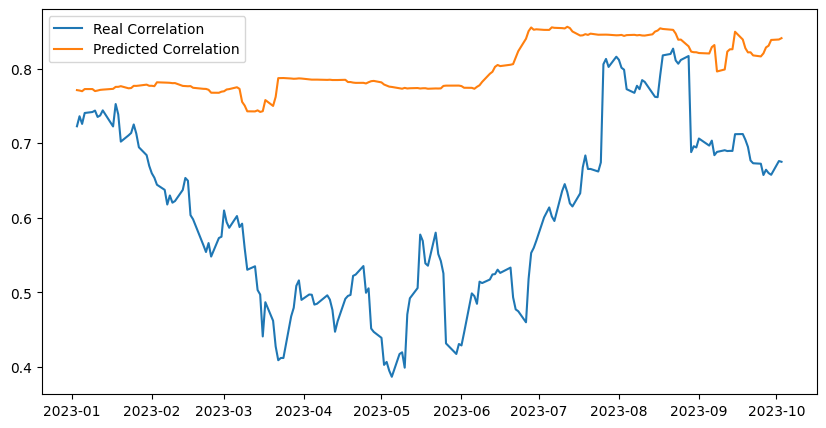

In [438]:
plt.figure(figsize = (10,5))
plt.plot(merged_df.loc['2023-01-01':].index,Y_test,label = 'Real Correlation')
plt.plot(merged_df.loc['2023-01-01':].index,predictions,label = 'Predicted Correlation')
plt.legend()
plt.show()

In [391]:
merged_df.loc['2023-01-01':].index

DatetimeIndex(['2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06',
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-17',
               ...
               '2023-09-20', '2023-09-21', '2023-09-22', '2023-09-25',
               '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29',
               '2023-10-02', '2023-10-03'],
              dtype='datetime64[ns]', name='Date', length=189, freq=None)

In [393]:
# model = Lasso(alpha = 1e-4)

model = RandomForestRegressor(n_estimators=100, max_depth=15)
model.fit(X_train[-60:], Y_train[-60:])

# 在测试集上进行预测
predictions = []

for i in range(1,len(X_test)):
    model = RandomForestRegressor(n_estimators=100, max_depth=15)
    model.fit(np.vstack([X_train[-60+i:], X_test[:i-1]]),np.hstack([Y_train[-60+i:], Y_test[:i-1]]))
    predictions.append(model.predict(X_test[i].reshape(1,-1))[0])

mse = mean_squared_error(Y_test[1:], predictions)

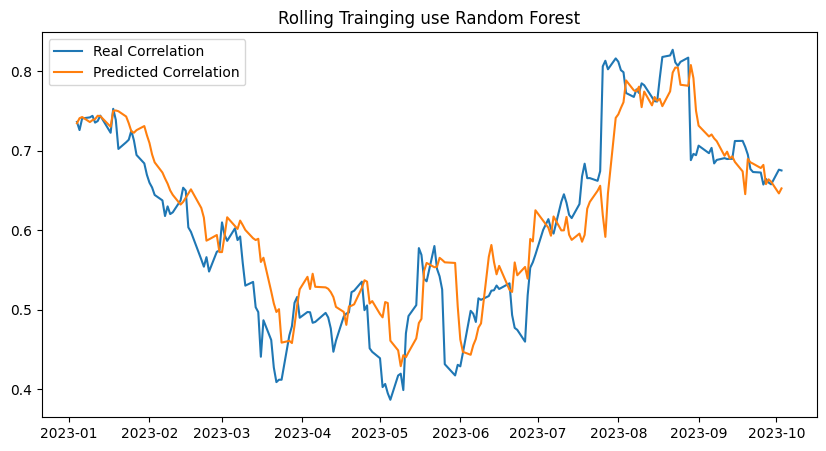

In [402]:
plt.figure(figsize = (10,5))
plt.plot(merged_df.loc['2023-01-01':].index[1:],Y_test[1:],label = 'Real Correlation')
plt.plot(merged_df.loc['2023-01-01':].index[1:],predictions,label = 'Predicted Correlation')
plt.title("Rolling Trainging use Random Forest")
plt.legend()
plt.show()

In [404]:
predictions_rolling = predictions

In [401]:
mean_squared_error(predictions,Y_test[1:])

0.0026264855762953548

In [309]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 100))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

model = LSTM_model()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

model.fit(X_train, 
          Y_train, 
          epochs=10, 
          batch_size = 256,
          validation_data=(x_valid, y_valid),
          callbacks = [checkpointer])

for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = Y_train[train_index], Y_train[val_index]

    model.fit(X_train, 
          Y_train, 
          epochs=10, 
          batch_size = 256,
          validation_data=(x_valid, y_valid),
          callbacks = [checkpointer])
    

NameError: name 'Sequential' is not defined

In [292]:
y_test = np.array(df_test_y)
x_test = np.reshape(df_test_x, (df_test_x.shape[0], df_test_x.shape[1] ,1))

price_pred_lstm = model.predict(x_test)

Date
2004-08-20         NaN
2004-08-23         NaN
2004-08-24         NaN
2004-08-25         NaN
2004-08-26    0.198195
                ...   
2023-09-27    0.668844
2023-09-28    0.665467
2023-09-29    0.662372
2023-10-02    0.663091
2023-10-03    0.666635
Name: label, Length: 4813, dtype: float64

In [267]:
np.shape(np.vstack([X_train[-60+i:], X_test[i]]))

(60, 313)

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=3),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5),
    'Support Vector Regression': SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam')
}


In [16]:
scaler.fit_transform(X)

array([[5.24259523e-05, 0.00000000e+00, 0.00000000e+00, ...,
        2.94457251e-01, 2.65035299e-01, 2.52396881e-01],
       [0.00000000e+00, 4.88700491e-05, 1.35281085e-04, ...,
        3.23013591e-01, 2.89260077e-01, 2.65857516e-01],
       [1.18603118e-04, 2.02215660e-04, 3.52595747e-04, ...,
        3.21763661e-01, 2.85755442e-01, 2.63184734e-01],
       ...,
       [9.21712403e-01, 9.19651610e-01, 9.12565141e-01, ...,
        2.06419839e-01, 1.91295238e-01, 1.82138207e-01],
       [9.23644769e-01, 9.23104410e-01, 9.15650444e-01, ...,
        1.95260629e-01, 1.91355057e-01, 1.82384574e-01],
       [9.21896426e-01, 9.23776945e-01, 9.17207976e-01, ...,
        1.81227541e-01, 1.91496657e-01, 1.82648841e-01]])

In [305]:
0.6*np.log(1.5) + 0.4*np.log(0.5)

-0.03397980735907949

In [313]:
data = yf.download("GOOG AMZN JPM GME XOM SPY", start="2000-01-01", end="2023-11-30", interval="1d")

close = data["Adj Close"]
returns = np.log(close).diff().dropna()

[*********************100%***********************]  6 of 6 completed


In [314]:
returns

,AMZN,GME,GOOG,JPM,SPY,XOM
Date,,,,,,
2004-08-20,0.022525,-0.008785,0.076433,0.016961,0.006994,0.003543
2004-08-23,-0.001520,-0.016010,0.010013,-0.002590,-0.002538,-0.005763
2004-08-24,-0.010191,0.013654,-0.042289,0.001037,0.001360,-0.003117
2004-08-25,0.031509,0.002356,0.010717,0.021788,0.006774,0.007552
2004-08-26,-0.002733,-0.007677,0.017859,0.000254,0.000000,0.001327
...,...,...,...,...,...,...
2023-11-22,0.019339,-0.020935,0.010049,0.002351,0.003853,-0.004317
2023-11-24,0.000204,-0.007350,-0.012939,0.001369,0.000615,0.005370
2023-11-27,0.006724,-0.024058,-0.001231,-0.002282,-0.001803,-0.005850


In [359]:
import numpy as np
import mgarch
import pandas as pd

# 假设returns是一个Pandas DataFrame，包含每天的股票收益率

window_size = 400  # 两个月的交易日
forecast_horizon = 40  # 预测的时间跨度，这里也是两个月
predicted_correlations = []  # 存储每个窗口的预测相关系数矩阵
actual_correlations = []  # 存储每个窗口对应的实际相关系数矩阵

# 滚动窗口预测
for i in range(4024, len(returns) - forecast_horizon):
    # 提取当前窗口的数据
    current_window_data = returns[i-window_size:i]

    # 创建MGARCH模型实例并拟合数据
    vol = mgarch.mgarch()
    vol.fit(current_window_data)

    # 预测下一天的协方差矩阵
    cov_nextday = vol.predict(10)
    # 将协方差矩阵转换为相关系数矩阵
    predicted_correlation = covariance_to_correlation(cov_nextday['cov'])
    predicted_correlations.append(predicted_correlation[3][2])

    # 计算实际的相关系数矩阵
    actual_data = returns[i:i + forecast_horizon]
    actual_correlation = actual_data.corr()
    actual_correlations.append(actual_correlation.iloc[3,2])

# 现在，你可以比较predicted_correlations和actual_correlations
# 例如，计算它们之间的均方误差
mse = mean_squared_error(predicted_correlations, actual_correlations)

print("Mean Squared Error:", mse)


KeyboardInterrupt: 

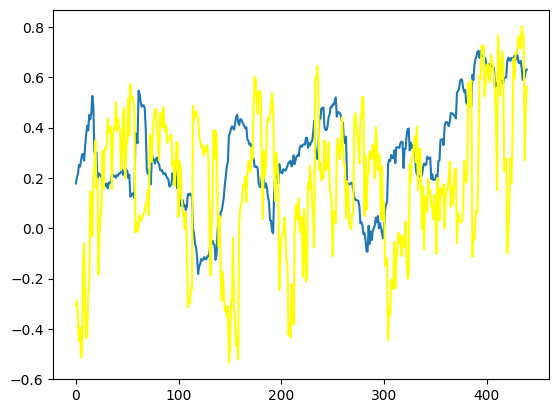

In [360]:
plt.plot(actual_correlations)
plt.plot(predicted_correlations,color = 'yellow')

In [348]:
predicted_correlation

array([[ 1.        , -0.42772294,  0.68207592, -0.27824921,  0.53285218,
        -0.45813263],
       [-0.42772294,  1.        , -0.4861985 ,  0.47659843,  0.09917654,
         0.77385706],
       [ 0.68207592, -0.4861985 ,  1.        ,  0.16142191,  0.52603828,
        -0.210161  ],
       [-0.27824921,  0.47659843,  0.16142191,  1.        ,  0.45384168,
         0.55439398],
       [ 0.53285218,  0.09917654,  0.52603828,  0.45384168,  1.        ,
         0.05893204],
       [-0.45813263,  0.77385706, -0.210161  ,  0.55439398,  0.05893204,
         1.        ]])

In [316]:
# shape(rt) = (t, n) numpy matrix with t days of observation and n number of assets
import mgarch
vol = mgarch.mgarch()
vol.fit(returns)
ndays = 1 # volatility of nth day
cov_nextday = vol.predict(ndays)

In [331]:
returns.index.get_loc('2023-01-03')

4624

In [323]:
import numpy as np

def covariance_to_correlation(covariance_matrix):
    """
    Convert a covariance matrix to a correlation matrix.
    
    Args:
    covariance_matrix (numpy.ndarray): A square covariance matrix.
    
    Returns:
    numpy.ndarray: The corresponding correlation matrix.
    """
    # Compute the standard deviation (sqrt of the diagonal elements)
    std_dev = np.sqrt(np.diag(covariance_matrix))
    
    # Create a diagonal qmatrix of the inverse of standard deviations
    inv_std_dev = np.diag(1 / std_dev)
    
    # Compute the correlation matrix
    correlation_matrix = inv_std_dev @ covariance_matrix @ inv_std_dev
    return correlation_matrix

In [326]:
covariance_to_correlation(cov_nextday['cov'])[4]

array([0.40428048, 0.04501215, 0.35900067, 0.47650366, 1.        ,
       0.10219645])

In [ ]:
# shape(rt) = (t, n) numpy matrix with t days of observation and n number of assets
import mgarch
dist = 't'
vol = mgarch.mgarch(dist)
vol.fit(rt)
ndays = 10 # volatility of nth day
cov_nextday = vol.predict(ndays)